# Importing Modules
Importing all the modules which we are going to use for this problem




In [ ]:
#!unzip dataset.zip

In [ ]:
import torch
import numpy as np
import random
import torchvision.utils
import torch.nn as nn
import torch.nn.functional as F
import operator
import matplotlib.pyplot as plt

from torchvision.transforms import Compose, ToTensor, Resize
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchsummary import summary
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.display import Image as IPImage


This function is used to create the test and training split of the dataset.

In [ ]:
def train_val_dataset(dataset, val_split=0.20):   
   
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['test'] = Subset(dataset, val_idx)
    
    return datasets

# Dataset Class
### sketch and photo are same

*   Label of 0 for positive pair

### sketch and photo are different
*   Label of 1 for imposter pair




In [ ]:
# Path for the Photo and Sketch 

photo_main_dir = "dataset/photo"
sketch_main_dir = "dataset/sketch"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/"My Drive"/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/dataset/sketch/snake/._n01729977_5390-2.png  
  inflating: dataset/sketch/snake/n01726692_2433-6.png  
  inflating: __MACOSX/dataset/sketch/snake/._n01726692_2433-6.png  
  inflating: dataset/sketch/snake/n01752165_3259-5.png  
  inflating: __MACOSX/dataset/sketch/snake/._n01752165_3259-5.png  
  inflating: dataset/sketch/snake/n01726692_80-6.png  
  inflating: __MACOSX/dataset/sketch/snake/._n01726692_80-6.png  
  inflating: dataset/sketch/snake/n01726692_7640-2.png  
  inflating: __MACOSX/dataset/sketch/snake/._n01726692_7640-2.png  
  inflating: dataset/sketch/snake/n01748264_1440-1.png  
  inflating: __MACOSX/dataset/sketch/snake/._n01748264_1440-1.png  
  inflating: dataset/sketch/snake/n01726692_9141-3.png  
  inflating: __MACOSX/dataset/sketch/snake/._n01726692_9141-3.png  
  inflating: dataset/sketch/snake/n01726692_182-1.png  
  inflating: __MACOSX/dataset/sketch/snake/._n01726692_182-1.png  
  inflating:

**For Photo** :

1.   List item
2.   List item


Splitting the Photo dataset into test and train

In [ ]:
dataset_p = ImageFolder(photo_main_dir)

dataset_photo = train_val_dataset(dataset_p)
dataset_photo_train_idx = dataset_photo['train'].indices    # Indices of photos for training from the dataset_p
dataset_photo_test_idx = dataset_photo['test'].indices      # Indices of photos for testing from the dataset_p

**For Sketch**: Spliting the Sketch dataset into test and train

In [ ]:
dataset_s = ImageFolder(sketch_main_dir)

dataset_sketch = train_val_dataset(dataset_s)
dataset_sketch_train_idx = dataset_sketch['train'].indices  # Indices of sketchs for training from the dataset_s
dataset_sketch_test_idx = dataset_sketch['test'].indices    # Indices of sketchs for testing from the dataset_s

Helper Class to print the image


In [ ]:
def imshow(img,text=None,should_save=False):
    '''
    This function takes an Image and prints the image. 
    '''
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
    
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
class SNDataset(Dataset):
    '''
    This class is used to generate an image tuple as a generator, which will randomly generate 
    a pair of (Image, Sketch, Match/Mismatch)
    '''
    def __init__(self,photoFolderDataset, sketchFolderDataset, 
                 photoFolderIndex, sketchFolderIndex,
                 transform=None, should_invert=False):
        
        self.photoFolderDataset = photoFolderDataset   
        self.sketchFolderDataset = sketchFolderDataset
        
        self.photoFolderIndex = photoFolderIndex
        self.sketchFolderIndex = sketchFolderIndex
        
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        '''
        This generator helps to randomly pick a pair of `Sketch and `Image`, which may be of same same 
        class or different class. Since we need to make sure, this generates, pair with roughly 
        same probability, with around 50% of the images of same class and rest of the other class.
        '''
        
        # Randomly picking the 1st sketch from the sketch dataset 
        img0_tuple = random.choice(self.sketchFolderDataset.imgs) 

        # This kind of assures we have roughly equal propability of the same and different class
        should_get_same_class = random.randint(0,1) 
        
        if should_get_same_class:
            while True:
                #  Looping till it gets the same class image is found
                img1_tuple = random.choice(self.photoFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                # Looping till it gets some different class image is found
                img1_tuple = random.choice(self.photoFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        # Returning the pair of (image, sketch, label) with a label indicating if its a match or mismatch
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return sum([len(self.photoFolderDataset.imgs), len(self.sketchFolderDataset.imgs)])

Creating the SNDataset object



In [ ]:
mydataset = SNDataset(photoFolderDataset=dataset_p,
                      sketchFolderDataset=dataset_s,
                      photoFolderIndex=dataset_photo_train_idx,
                      sketchFolderIndex=dataset_sketch_train_idx,
                      transform=transforms.Compose([transforms.Resize((100,100)),
                                                    transforms.ToTensor()
                                                   ]),
                     )


view the Images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


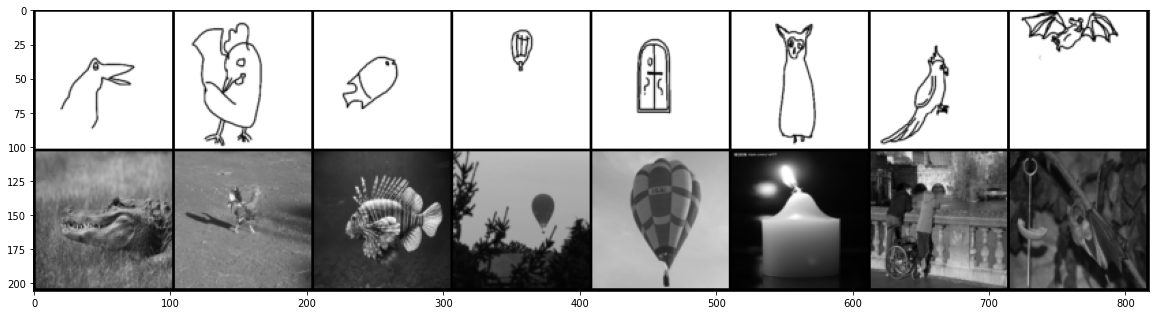

Class of the above pair of images, 0 indicates MATCH, 1 indicates MISMATCH

[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [ ]:
my_dataloader = DataLoader(mydataset,
                           shuffle=True,
                           num_workers=8,
                           batch_size=8)
dataiter = iter(my_dataloader)

one_batch = next(dataiter)
concatenated = torch.cat((one_batch[0],one_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print("Class of the above pair of images, 0 indicates MATCH, 1 indicates MISMATCH\n")
print(one_batch[2].numpy())

Defining the CNN


In [ ]:
class SN(nn.Module):
    '''
    Network used is a simple CNN, with:
    Conv2d-> ReLU -> BatchNorm2d -> Conv2d -> ReLU -> BatchNorm2d -> Conv2d -> ReLU -> BatchNorm2d

    Followed by a fully connected layer:
    Linear -> ReLU -> Linear -> ReLU -> Linear
    '''
    def __init__(self):
        super(SN, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

        

**Training**
Setting hyperparameters

In [ ]:
train_batch_size = 128
train_number_epochs = 100
learning_rate = 0.0005

train_dataloader = DataLoader(mydataset,
                              shuffle=True,
                              num_workers=32,
                              batch_size=train_batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Contrastive *Loss*

In [ ]:
class CLoss(torch.nn.Module):
    '''
    Since, we are using Siamese Architecture and we are not classifying the input images, 
    but to needed a mechanism to differentiate between them. So, instead of using any classification 
    loss function, this architecture is better suited to use a contrastive function. 
    And in a nutshell this function simply evaluates how well the network is able to distinguish 
    a given pair of images.
    '''
    def __init__(self, margin=2.0):
        super(CLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
!pip install mxnet-cu80
!nvcc --version

     |████████████████████████████████| 372.1MB 45kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
net = SN().cuda()
criterion = CLoss()
optimizer = optim.Adam(net.parameters(),lr = learning_rate)

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(train_number_epochs):
    '''
    Training Starts here
    '''
    for i, data in enumerate(train_dataloader,0):
        
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        
        optimizer.zero_grad()
        
        output1,output2 = net(img0,img1)
        
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        
        optimizer.step()
        
        if i %100 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=100
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
            
show_plot(counter,loss_history)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch number 0
 Current loss 1.8044357299804688

Epoch number 0
 Current loss 1.039690375328064

Epoch number 0
 Current loss 1.044981837272644

Epoch number 0
 Current loss 1.182814121246338

Epoch number 0
 Current loss 1.0593528747558594

Epoch number 0
 Current loss 1.1631395816802979

Epoch number 0
 Current loss 1.103510856628418

Epoch number 1
 Current loss 1.058159589767456

Epoch number 1
 Current loss 1.0166730880737305

Epoch number 1
 Current loss 0.9844281077384949

Epoch number 1
 Current loss 0.9437136650085449

Epoch number 1
 Current loss 1.0606999397277832

Epoch number 1
 Current loss 1.0314478874206543

Epoch number 1
 Current loss 0.9652814269065857

Epoch number 2
 Current loss 0.9909290075302124

Epoch number 2
 Current loss 1.0507506132125854

Epoch number 2
 Current loss 1.0091609954833984

Epoch number 2
 Current loss 0.9413726329803467

Epoch number 2
 Current loss 0.9664420485496521

Epoch number 2
 Current loss 0.9226458072662354

Epoch number 2
 Current l

Testing(Inference)


In [ ]:

def imshow_inference(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  

Saving the Model

In [ ]:
PATH = "ModelForCourseProject.pt"

# Save
torch.save(net, PATH)

In [ ]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')

In [ ]:
# Load the model 
PATH = "ModelForCourseProject.pt"
net = torch.load(PATH)
net.eval()

criterion = CLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
siamese_dataset = SNDataset(photoFolderDataset=dataset_p,
                                        sketchFolderDataset=dataset_s,
                                        photoFolderIndex=dataset_photo_test_idx,
                                        sketchFolderIndex=dataset_sketch_test_idx,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)


test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,, = next(dataiter)

counter = 0
for i in range(len(dataset_photo_train_idx)):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    if euclidean_distance.item() < .3:
        imshow_inference(torchvision.utils.make_grid(concatenated),'Similarity: {:.2f}'.format(1-euclidean_distance.item()))
        counter += 1
    if counter >= 10:
        break